# Using a ML model to recommend content (e.g., movies, articles, songs) to users based on preferences or features

In [2]:
import pandas as pd

## Load Data
I will be using this data set https://grouplens.org/datasets/movielens/ for my Portfolio Project. This data set has 100000 ratings by 943 users on 1682 items

In [3]:
# Load ratings
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=column_names)

# Load movie information
movie_columns = [
    'item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
    'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', names=movie_columns)

# Merge ratings with movie metadata
data = pd.merge(ratings, movies, on='item_id')

# Drop unused columns
data = data.drop(['timestamp', 'release_date', 'video_release_date', 'IMDb_URL'], axis=1)

# Preview
data.head()

,user_id,item_id,rating,title,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,Kolya (1996),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,L.A. Confidential (1997),0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,Heavyweights (1994),0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,Legends of the Fall (1994),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,Jackie Brown (1997),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Checks for Missing Data and Other Preprocessing
**MovieLens 100K dataset** https://grouplens.org/datasets/movielens/100k/ which I am using is **very clean** and was curated specifically for ML research. This data has been cleaned up - users who had less than 20 ratings or did not have complete demographic information were removed from this data set, so I am expecting that **minimal preprocessing is needed**

#### Check for Missing Values

In [4]:
print("Missing values in ratings + metadata:")
print(data.isnull().sum())
# Expected result: all zeros (no missing values)

Missing values in ratings + metadata:
user_id        0
item_id        0
rating         0
title          0
unknown        0
Action         0
Adventure      0
Animation      0
Children       0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64


#### Check for Duplicates

In [5]:
print("Number of duplicate rows:", data.duplicated().sum())
# There shouldn't be any duplicates

Number of duplicate rows: 0


## Prepare Features and Labels

We'll make a binary classification problem:
1 if rating ≥ 4 → user liked the movie, 0 otherwise and use genres as features.

In [6]:
# Create binary target variable
data['liked'] = data['rating'] >= 4

# Use genre columns as features
genre_cols = movie_columns[6:]  # All genre columns
X = data[genre_cols]
y = data['liked'].astype(int)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (100000, 18)
Target vector shape: (100000,)


### Check for Class Imbalance

The proportion represents about a 55:45 split, which is relatively balanced compared to severe imbalances we might see in some other datasets (like 90:10 or worse). Most algorithms should handle this reasonably well without major modifications.

In [7]:
print(data['liked'].value_counts(normalize=True))

liked
True     0.55375
False    0.44625
Name: proportion, dtype: float64


# Train/ Validation / Test split
##### Step 1: First split the data into train+val and test.
##### Step 2: Split train+val into train and validation.
##### Note: 0.25 * 0.8 = 0.2 → so you get 60% train, 20% val, 20% test.


In [8]:
from sklearn.model_selection import train_test_split

# Step 1: First split the data into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Split train+val into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
# Note: 0.25 * 0.8 = 0.2 → so you get 60% train, 20% val, 20% test

print("Train size:", len(y_train))
print("Validation size:", len(y_val))
print("Test size:", len(y_test))

Train size: 60000
Validation size: 20000
Test size: 20000


# Train the Model and Validate using Decision Tree Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize and train the Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Validate on the validation set
y_val_pred_dt = dt.predict(X_val)
print("Decision Tree - Validation Performance:\n")
print(classification_report(y_val, y_val_pred_dt))

Decision Tree - Validation Performance:

              precision    recall  f1-score   support

           0       0.59      0.42      0.49      8925
           1       0.62      0.76      0.68     11075

    accuracy                           0.61     20000
   macro avg       0.60      0.59      0.59     20000
weighted avg       0.61      0.61      0.60     20000



# Evaluation on Test Set

In [10]:
# Test set performance
y_test_pred_dt = dt.predict(X_test)
print("Decision Tree - Test Performance:\n")
print(classification_report(y_test, y_test_pred_dt))

Decision Tree - Test Performance:

              precision    recall  f1-score   support

           0       0.58      0.42      0.49      8925
           1       0.62      0.75      0.68     11075

    accuracy                           0.60     20000
   macro avg       0.60      0.59      0.58     20000
weighted avg       0.60      0.60      0.59     20000



# Visualize the tree

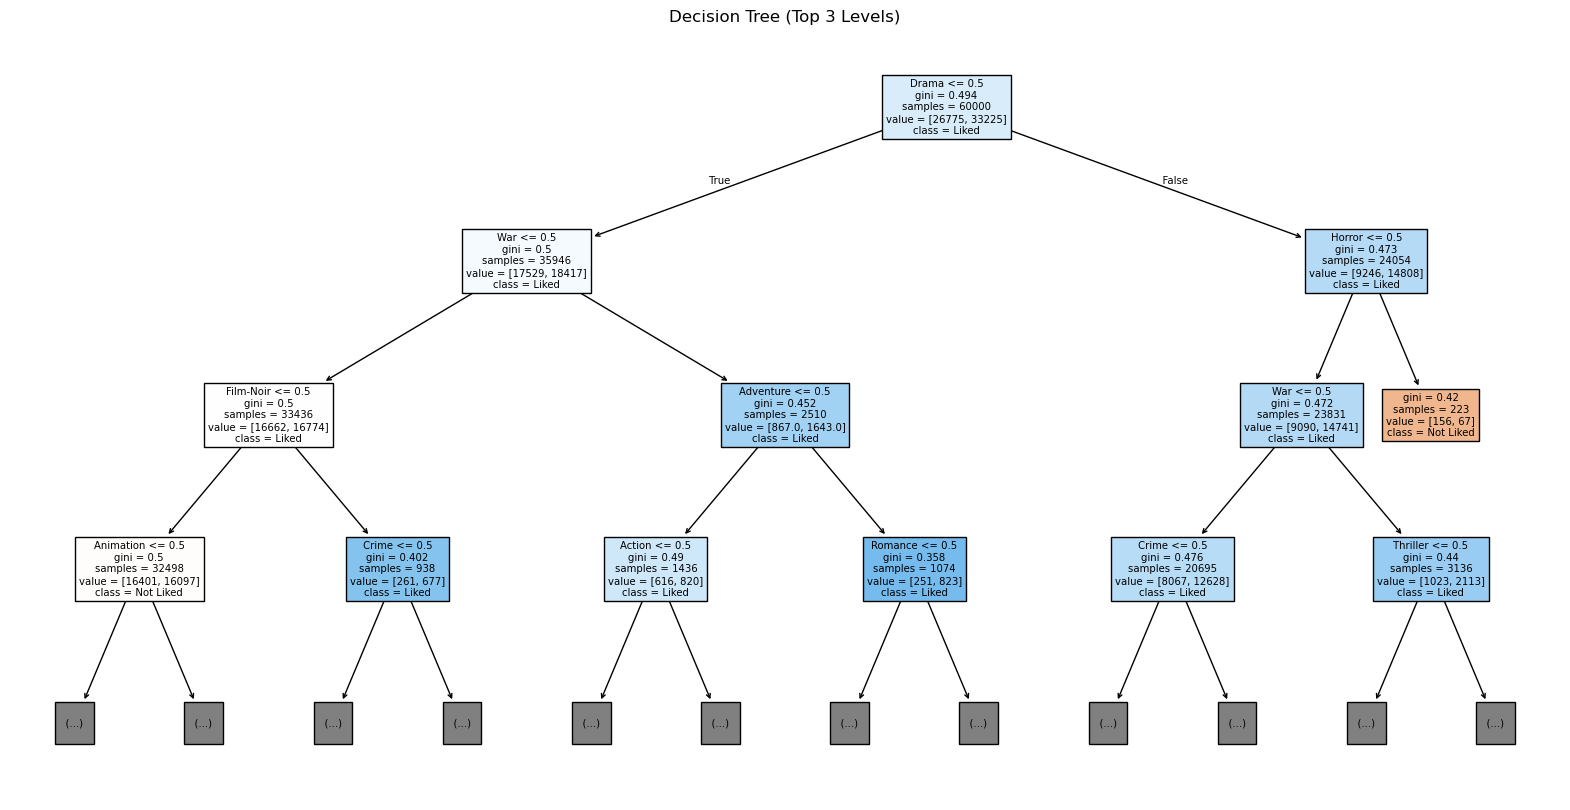

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=['Not Liked', 'Liked'], filled=True, max_depth=3)
plt.title("Decision Tree (Top 3 Levels)")
plt.show()


# Hyperparameter Tuning

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define parameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create base model
dt = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='f1_weighted',  # or 'accuracy', 'precision_weighted', etc.
    n_jobs=-1,
    verbose=2
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", grid_search.best_params_)
best_dt = grid_search.best_estimator_

# Predict on test set
y_pred = best_dt.predict(X_test)

# Evaluate
print("\nDecision Tree (Tuned) - Test Performance:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Decision Tree (Tuned) - Test Performance:
              precision    recall  f1-score   support

           0       0.58      0.42      0.49      8925
           1       0.62      0.75      0.68     11075

    accuracy                           0.60     20000
   macro avg       0.60      0.59      0.58     20000
weighted avg       0.60      0.60      0.59     20000

